In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

In [3]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  316
Number of subjects who completed the second session:  149


In [4]:
# print('------first session------')
# for f in files_firstSess:
#     print(f)
    
# print('------second session------')
# for f in files_secondSess:
#     print(f)


# Data cleaning
## Check if all experiments are completed

In [5]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        # print(files[sess])
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [6]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (167 files total)


In [7]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (149 files total)


## Acquire thresholds for all tasks

### Functions:

In [8]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_logThresholds = {}

        # print(files[sess])
        # print(mainOutput['ProlificParticipantID'].dropna())
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_logThresholds['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]

            if exclude_trial_count_bool: 
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())
                if not trial_sent_bool:
                    subj_logThresholds[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    subj_logThresholds[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
        
        all_data.append(subj_logThresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [9]:
def getRSVPThresholds(mydir, files, condition_names, num_trials_per_staircase=24,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            # Extract threshold: 
            # check that only 1 threshold is reported for this condition
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            if exclude_trial_count_bool: 
                        
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())

                if not trial_sent_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                
                if not small_questSD_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [10]:
def getOrdReadingSpeed(mydir, files, condition_dict,
                       accuracy_criterion_percent=60, wpm_criterion=400):
    '''
    accuracy_criterion_percent: the reading speed will be marked as np.nan if the accuracy for the comprehension question
                                is lower than this percentage
    wpm_criteiron: the reading speed will be marked as np.nan if it is higher than this percentage
    '''
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            # calculate reading speed
            speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
            numWords = speed_data['readingPageWords'].dropna()
            reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
            pg_wordsPerMin = numWords / (reading_time / 60)
            include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
            subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            if percent_correct < accuracy_criterion_percent: 
                # print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan

            if np.mean(include_wordsPerMin) > wpm_criterion:
                # print(f'Warning: ordinary reading speed is too high: session {sess}, passage {cat}')
                # print(f'-- wpm: {np.mean(include_wordsPerMin)}')
                subj_wpm[condition_name] = np.nan

    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            

### Acquire thresholds:

- Note that data acquired for RSVP and Ordinary reading are in words per min -- not logged

- All the other thresholds are logged

- As of March 16th, I'm not excluding any data, as we only have a few participants and somehow excluding data based on our exclusion criteria excludes too much data. The codes are ready for excluding data based on our pre-determined exclusion criteria; we can exclude data once we get more participants.

In [11]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'vernier_R8_block1','vernier_L8_block1',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1, exclude_trial_count_bool=False, exclude_questSD=False)

thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
df_firstSess_rsvp = getRSVPThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, exclude_trial_count_bool=False, exclude_questSD=False)

thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1, accuracy_criterion_percent=60, wpm_criterion=400)

In [12]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'vernier_R8_block2','vernier_L8_block2',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2, exclude_trial_count_bool=False, exclude_questSD=False)

thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
df_secondSess_rsvp = getRSVPThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, exclude_trial_count_bool=False, exclude_questSD=False)

thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2, accuracy_criterion_percent=60, wpm_criterion=1000)


In [13]:
# merge data frames

df_first_merge = pd.merge(df_firstSess, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")


df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")
display(df_both_sessions)
# print(df_both_sessions.columns)

,prolificID,crowding_R8_block1,crowding_L8_block1,crowding_R8_block2,crowding_L8_block2,vernier_R8_block1,vernier_L8_block1,acuity_R8_block1,acuity_L8_block1,rsvp_foveal_block1,...,crowding_L8_block3,crowding_R8_block4,crowding_L8_block4,vernier_R8_block2,vernier_L8_block2,acuity_R8_block2,acuity_L8_block2,rsvp_foveal_block2,reading_Desert_block1,reading_Islands_block2
0,5f0788c06b220f03231666a0,0.043957,0.179236,-0.126747,0.289660,-1.305725,-1.576289,-0.472122,-0.477837,1832.333039,...,0.147248,0.090430,0.063827,-1.705747,-1.550973,-0.438854,-0.482988,2058.248826,488.274668,414.882562
1,6778842e3f7e2e62756f7178,0.396150,0.489160,0.262959,0.372813,-0.822318,-1.622256,-0.292501,-0.436618,2403.490021,...,0.408823,0.239514,0.390076,-0.874235,-1.120961,-0.227708,-0.505052,3045.424347,246.629506,232.801102
2,5e57d38b533eec1818078f0b,0.518647,0.504546,0.512413,0.402477,-0.697787,-0.563078,-0.499952,-0.467355,1292.339711,...,0.544390,0.456857,0.511064,-0.821911,-1.075505,-0.494149,-0.535377,689.934125,335.418610,236.760314
3,6501b789e3ddbc0a0b79b925,0.345837,0.519481,0.065965,0.092024,1.281983,1.647160,-0.381091,-0.434908,2144.733782,...,0.343975,0.459395,0.330276,1.644361,1.579288,-0.413117,-0.514619,2058.248826,359.826277,391.986960
4,5cb206ee3d6647001724d5af,0.268226,0.445264,0.003865,0.001146,-1.180635,-1.409205,-0.506763,-0.533609,2013.764981,...,0.211268,-0.371533,0.404489,-1.313381,-1.458311,-0.543589,-0.562162,2141.433949,239.076402,221.294425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,67657279b0bce380fa33721e,0.408247,0.633470,0.223808,0.441443,-1.052754,-1.410628,-0.565340,-0.431751,1338.056079,...,0.261801,0.717580,0.589504,-1.241968,-1.433003,-0.434700,-0.430689,2705.330354,149.910218,203.325213
142,67769375527d252db09e7d60,0.434215,0.533588,0.435980,0.506025,-0.503154,-1.275827,-0.471064,-0.589064,1314.796264,...,0.476356,0.116988,0.294287,-1.301419,-1.681892,-0.551354,-0.542098,2016.104674,301.609646,375.525822
143,5e7bc6522b3c381f6e3c1b3f,0.216478,0.539739,0.386782,0.474084,-1.459059,-1.054321,-0.550021,-0.406205,2099.224626,...,0.409480,0.499841,0.603218,-1.368541,-1.385205,-0.533336,-0.499229,1995.374576,203.895137,127.863250
144,5cad1eef8ed53d00180d2532,0.057994,0.700502,0.342772,0.543862,-1.167251,-1.025662,-0.463320,-0.502274,2614.415047,...,0.566190,0.226315,0.447489,-1.148598,-1.555068,-0.554775,-0.464227,5672.648952,234.430187,168.824738


## Histograms of all thresholds

In [14]:
def extract_all_thresholds(dfs, col_name, calculate_bouma_bool=False):
    '''
    inputs:
    - dfs: an array of data frames containing thresholds
    - col_name: [string] the name of the columns we want to select
    - calculate_bouma_bool: [bool] if True, then it divides the threshold by eccentricity
    output:
    - returns an array of concatenated data
    '''
    
    data = []
    
    for df in dfs:
        all_columns = [col for col in df.columns if col.startswith(col_name)]
        all_values = df[all_columns].values.flatten()
        data.extend(all_values)
    
    data_array = np.array(data)

    if calculate_bouma_bool:
        eccentricity = 8
        data_array = 10 ** data_array / eccentricity
    
    return data_array

dfs = [df_first, df_second]

In [15]:
def plot_threshold_array(data_array, threshold_name,
                         num_bins=20, min_val=0.08, max_val=1.11, plot_JOV_patch=False):
    '''
    Input:
    - data_array: an array of data (could be output from extract_all_thresholds)
    - threshold_name: [string] title and x-axis label of the figure
    - plot_JOV_patch: [bool] plots mean +- 1 sd from crowding data (Kurzawski, Burchell et al., 2023, JOV) 
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    
    plt.figure(figsize=(8, 4)) 
    if plot_JOV_patch:
        lowerBound = 0.18
        upperBound = 0.41
        plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
    
    plt.hist(data_array, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(threshold_name, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xscale('log')
    # plt.xlim(0.07,1.2)
    # plt.ylim(0,125)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

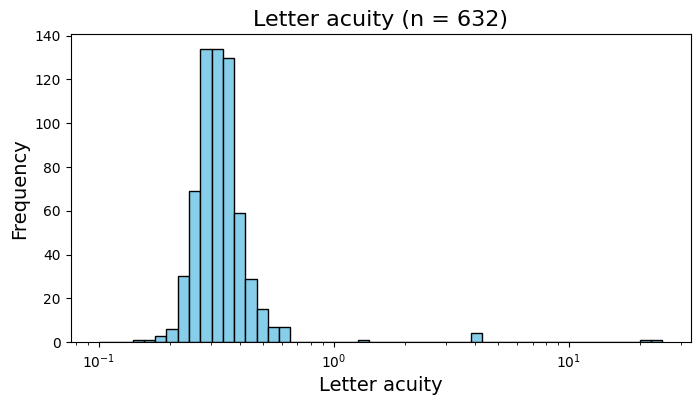

In [16]:
all_letter_acuity = 10 ** extract_all_thresholds(dfs, 'acuity')
plot_threshold_array(all_letter_acuity, 'Letter acuity',num_bins=50, min_val=0.1, max_val=25)

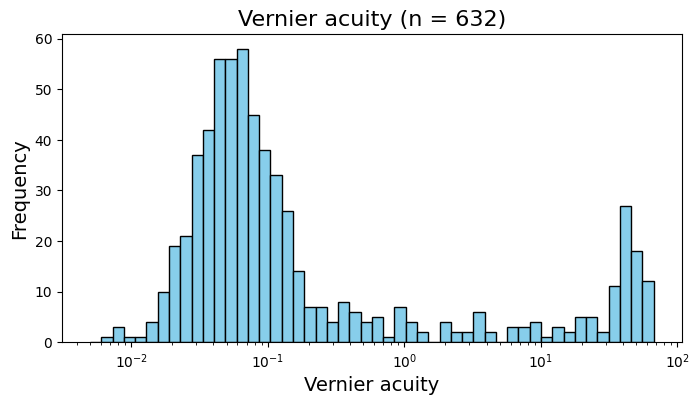

In [17]:
all_vernier_acuity = 10 ** extract_all_thresholds(dfs, 'vernier')
plot_threshold_array(all_vernier_acuity, 'Vernier acuity',num_bins=50, min_val=0.005, max_val=67)

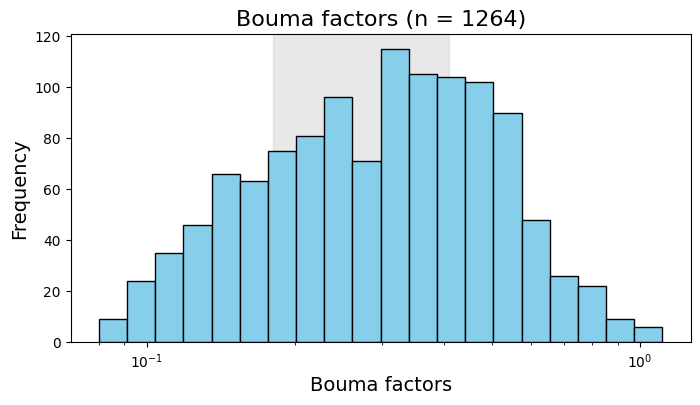

In [18]:
bouma = extract_all_thresholds(dfs, 'crowding', calculate_bouma_bool=True)
plot_threshold_array(bouma, 'Bouma factors', plot_JOV_patch=True)

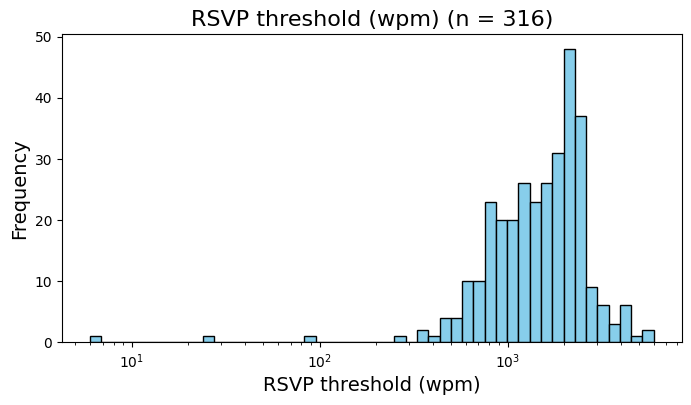

In [19]:
all_rsvp = extract_all_thresholds(dfs, 'rsvp')
plot_threshold_array(all_rsvp, 'RSVP threshold (wpm)',num_bins=50, min_val=6, max_val=6000)

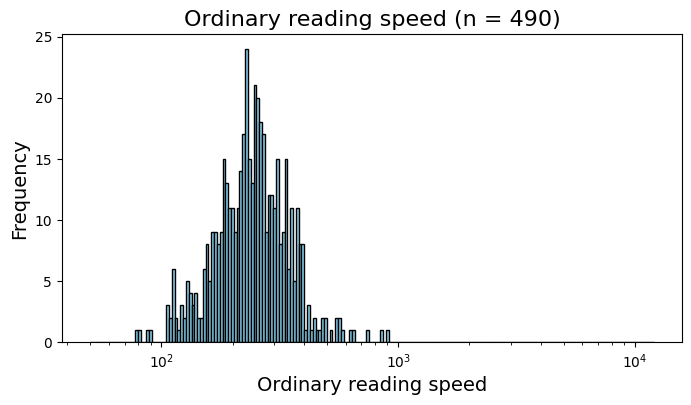

In [20]:
all_ord_wpm = extract_all_thresholds(dfs, 'reading')
plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=200, min_val=50, max_val=12000)

# Analysis

### Test-retest

In [21]:
df_both_sessions['crowding_R8_12'] = (df_both_sessions['crowding_R8_block1'] + 
                                      df_both_sessions['crowding_R8_block2']) / 2

df_both_sessions['crowding_L8_12'] = (df_both_sessions['crowding_L8_block1'] + 
                                      df_both_sessions['crowding_L8_block2']) / 2

df_both_sessions['crowding_R8_34'] = (df_both_sessions['crowding_R8_block3'] + 
                                      df_both_sessions['crowding_R8_block4']) / 2

df_both_sessions['crowding_L8_34'] = (df_both_sessions['crowding_L8_block3'] + 
                                      df_both_sessions['crowding_L8_block4']) / 2

In [22]:
df_both_sessions['ordreading_sess1'] = 10 ** ((np.log10(df_both_sessions['reading_Beaver_block1']) + 
                                               np.log10(df_both_sessions['reading_Winter_block2'])) / 2)

df_both_sessions['ordreading_sess2'] = 10 ** ((np.log10(df_both_sessions['reading_Desert_block1']) + 
                                               np.log10(df_both_sessions['reading_Islands_block2'])) / 2)

In [38]:
def plot_scatter_with_correlation(df, var_x, var_y, title, plotXequalsY_bool=False):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Ensure aspect ratio is equal for x and y
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Show plot
    plt.show()


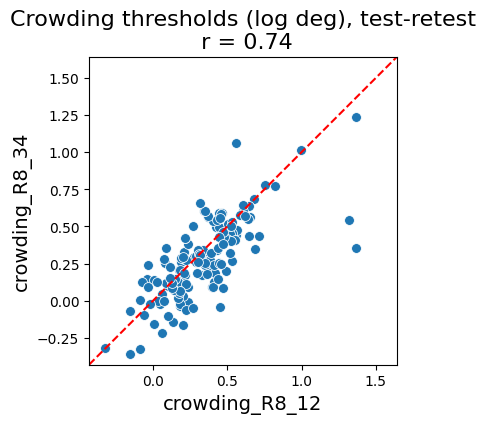

In [39]:
plot_scatter_with_correlation(df_both_sessions, "crowding_R8_12", "crowding_R8_34", 
                              'Crowding thresholds (log deg), test-retest', plotXequalsY_bool=True)


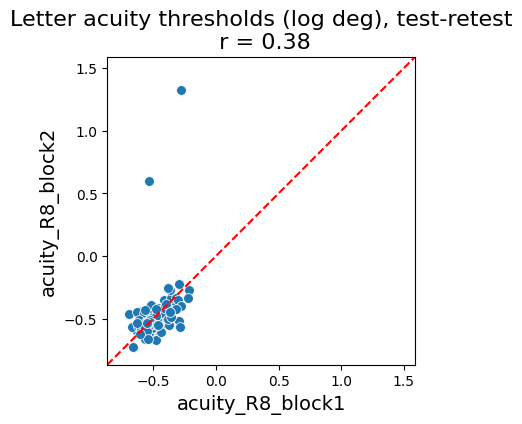

In [40]:
plot_scatter_with_correlation(df_both_sessions, "acuity_R8_block1", "acuity_R8_block2", 
                              'Letter acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


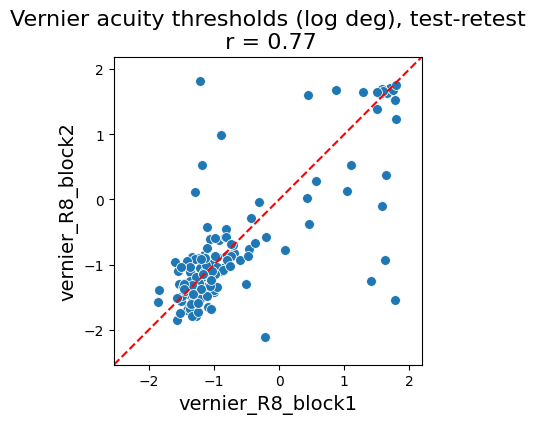

In [41]:
plot_scatter_with_correlation(df_both_sessions, "vernier_R8_block1", "vernier_R8_block2", 
                              'Vernier acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


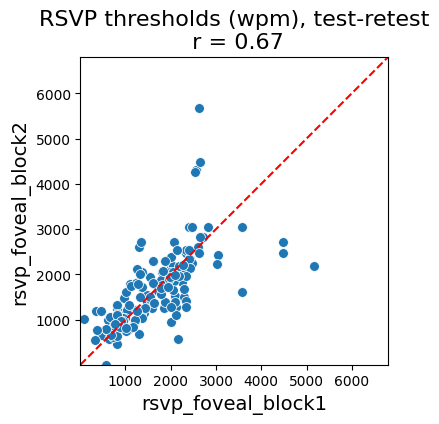

In [42]:
plot_scatter_with_correlation(df_both_sessions, "rsvp_foveal_block1", "rsvp_foveal_block2", 
                              'RSVP thresholds (wpm), test-retest', plotXequalsY_bool=True)


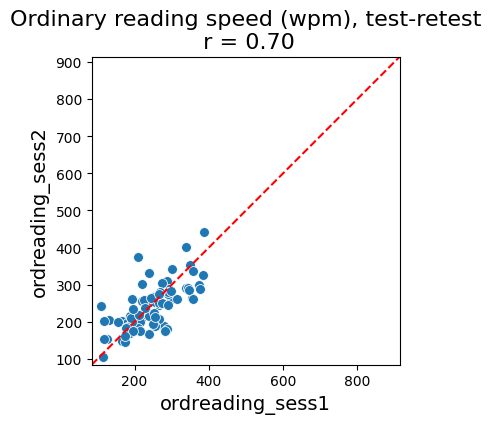

In [43]:
plot_scatter_with_correlation(df_both_sessions, "ordreading_sess1", "ordreading_sess2", 
                              'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

### Average over repeats for each participant

In [44]:
# average between sessions

subj_avg_thresholds = {}


subj_avg_thresholds['crowding_R8'] = (df_both_sessions['crowding_R8_12'] + 
                                      df_both_sessions['crowding_R8_34']) / 2
subj_avg_thresholds['crowding_L8'] = (df_both_sessions['crowding_L8_12'] + 
                                      df_both_sessions['crowding_L8_34']) / 2
subj_avg_thresholds['crowding_RL'] = (subj_avg_thresholds['crowding_R8'] + 
                                      subj_avg_thresholds['crowding_L8']) / 2

subj_avg_thresholds['acuity_R8'] = (df_both_sessions['acuity_R8_block1'] + 
                                      df_both_sessions['acuity_R8_block2']) / 2
subj_avg_thresholds['acuity_L8'] = (df_both_sessions['acuity_L8_block1'] + 
                                      df_both_sessions['acuity_L8_block2']) / 2
subj_avg_thresholds['acuity_RL'] = (subj_avg_thresholds['acuity_R8'] + 
                                      subj_avg_thresholds['acuity_L8']) / 2

subj_avg_thresholds['vernier_R8'] = (df_both_sessions['vernier_R8_block1'] + 
                                      df_both_sessions['vernier_R8_block2']) / 2
subj_avg_thresholds['vernier_L8'] = (df_both_sessions['vernier_L8_block1'] + 
                                      df_both_sessions['vernier_L8_block2']) / 2
subj_avg_thresholds['vernier_RL'] = (subj_avg_thresholds['vernier_R8'] + 
                                      subj_avg_thresholds['vernier_L8']) / 2

subj_avg_thresholds['rsvp_log'] =  ((np.log10(df_both_sessions['rsvp_foveal_block1']) + 
                                      np.log10(df_both_sessions['rsvp_foveal_block2'])) / 2)

subj_avg_thresholds['ordinary_reading_log'] = ((np.log10(df_both_sessions['ordreading_sess1']) + 
                                               np.log10(df_both_sessions['ordreading_sess2'])) / 2)

df_subj_avg = pd.DataFrame(subj_avg_thresholds)
df_subj_avg.head()

,crowding_R8,crowding_L8,crowding_RL,acuity_R8,acuity_L8,acuity_RL,vernier_R8,vernier_L8,vernier_RL,rsvp_log,ordinary_reading_log
0,0.051286,0.169993,0.110639,-0.455488,-0.480413,-0.467951,-1.505736,-1.563631,-1.534684,3.288251,NaN
1,0.249812,0.415218,0.332515,-0.260104,-0.470835,-0.365470,-0.848276,-1.371608,-1.109942,3.432245,2.371740
2,0.471304,0.490619,0.480962,-0.497051,-0.501366,-0.499208,-0.759849,-0.819291,-0.789570,2.975092,NaN
3,0.267549,0.321439,0.294494,-0.397104,-0.474764,-0.435934,1.463172,1.613224,1.538198,3.322436,2.447886
4,-0.002561,0.265542,0.131490,-0.525176,-0.547885,-0.536531,-1.247008,-1.433758,-1.340383,3.317357,NaN


### Is there left-right asymmetry?

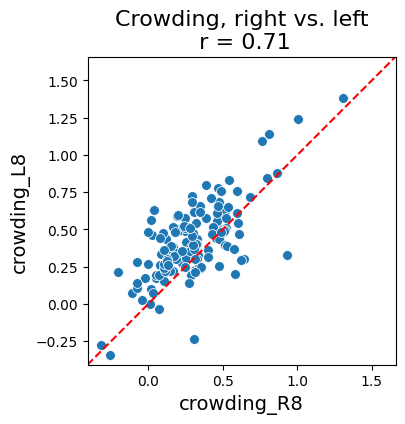

In [45]:
plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
                              'Crowding, right vs. left', plotXequalsY_bool=True)

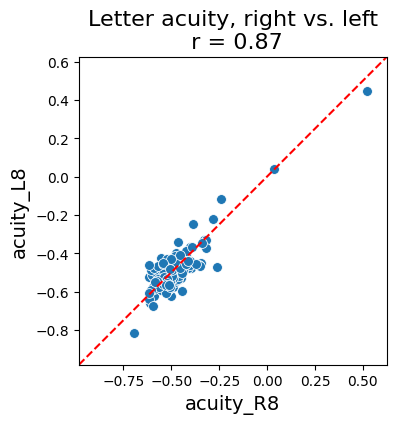

In [46]:
plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
                              'Letter acuity, right vs. left', plotXequalsY_bool=True)

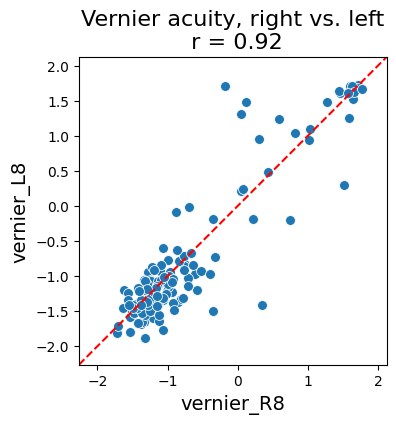

In [47]:
plot_scatter_with_correlation(df_subj_avg, "vernier_R8", "vernier_L8", 
                              'Vernier acuity, right vs. left', plotXequalsY_bool=True)

### Correlation between tasks

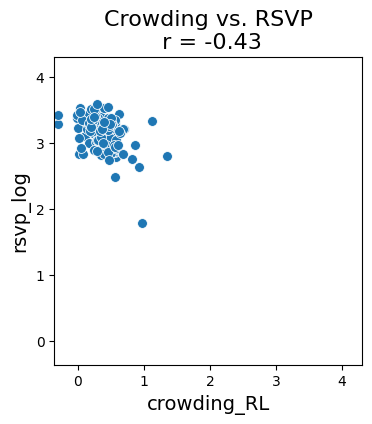

In [48]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "rsvp_log", 
                              'Crowding vs. RSVP')

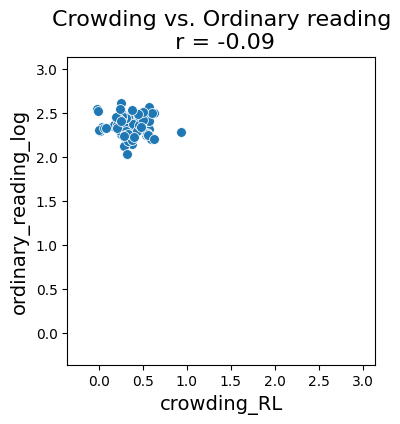

In [49]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "ordinary_reading_log", 
                              'Crowding vs. Ordinary reading')

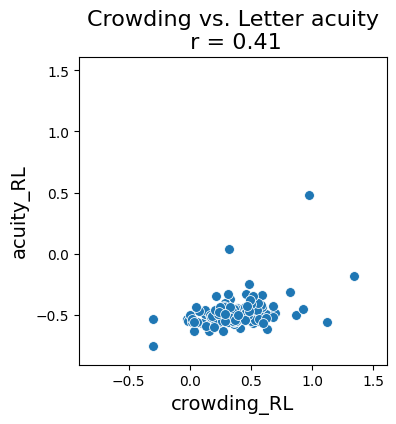

In [50]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "acuity_RL", 
                              'Crowding vs. Letter acuity')

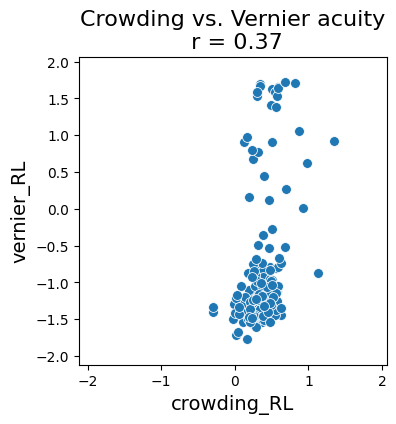

In [51]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "vernier_RL", 
                              'Crowding vs. Vernier acuity')

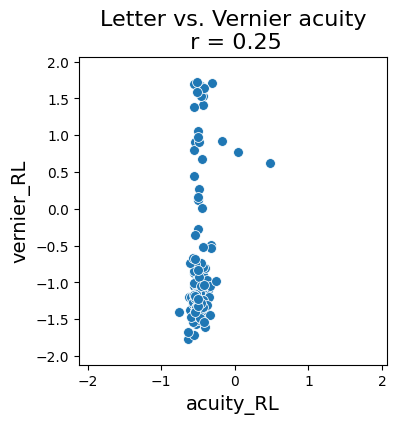

In [52]:
plot_scatter_with_correlation(df_subj_avg, "acuity_RL", "vernier_RL", 
                              'Letter vs. Vernier acuity')